# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from gwpy.timeseries import TimeSeries
import astropy.units as u

In [3]:
from tqdm.notebook import tqdm
import ringdown as rd

## PE results

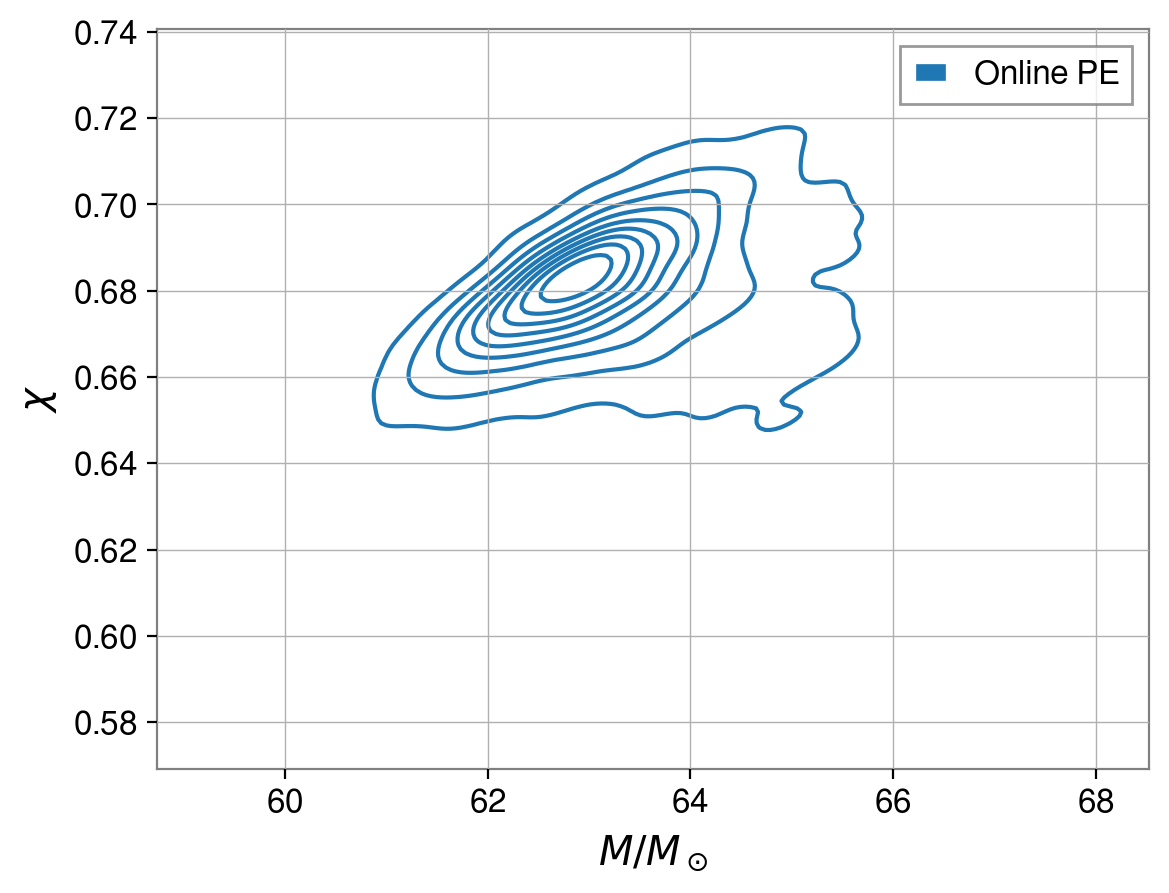

In [4]:
pe = np.genfromtxt('online_pesummary.dat', names=True)
l, = pl.plot([], [], label='Online PE')
sns.kdeplot(x=pe['final_mass'], y=pe['final_spin'], color=l.get_color())
pl.xlabel(r'$M / M_\odot$')
pl.ylabel(r'$\chi$')
pl.legend()

In [5]:
pe_fs = {}
pe_gammas = {}
with tqdm(total=28) as pbar:
    for l in [2,3]:
        for m in range(0, l+1):
            for n in [0,1,2,3]:
                fs = []
                gammas = []
                for s in pe:
                    f,t = rd.qnms.get_ftau(s['final_mass'], s['final_spin'], l=l, m=m, n=n)
                    fs.append(f)
                    gammas.append(1/t)
                pe_fs[(l,m,n)] = np.array(fs)
                pe_gammas[(l,m,n)] = np.array(gammas)

                pbar.update(1)

  0%|          | 0/28 [00:00<?, ?it/s]

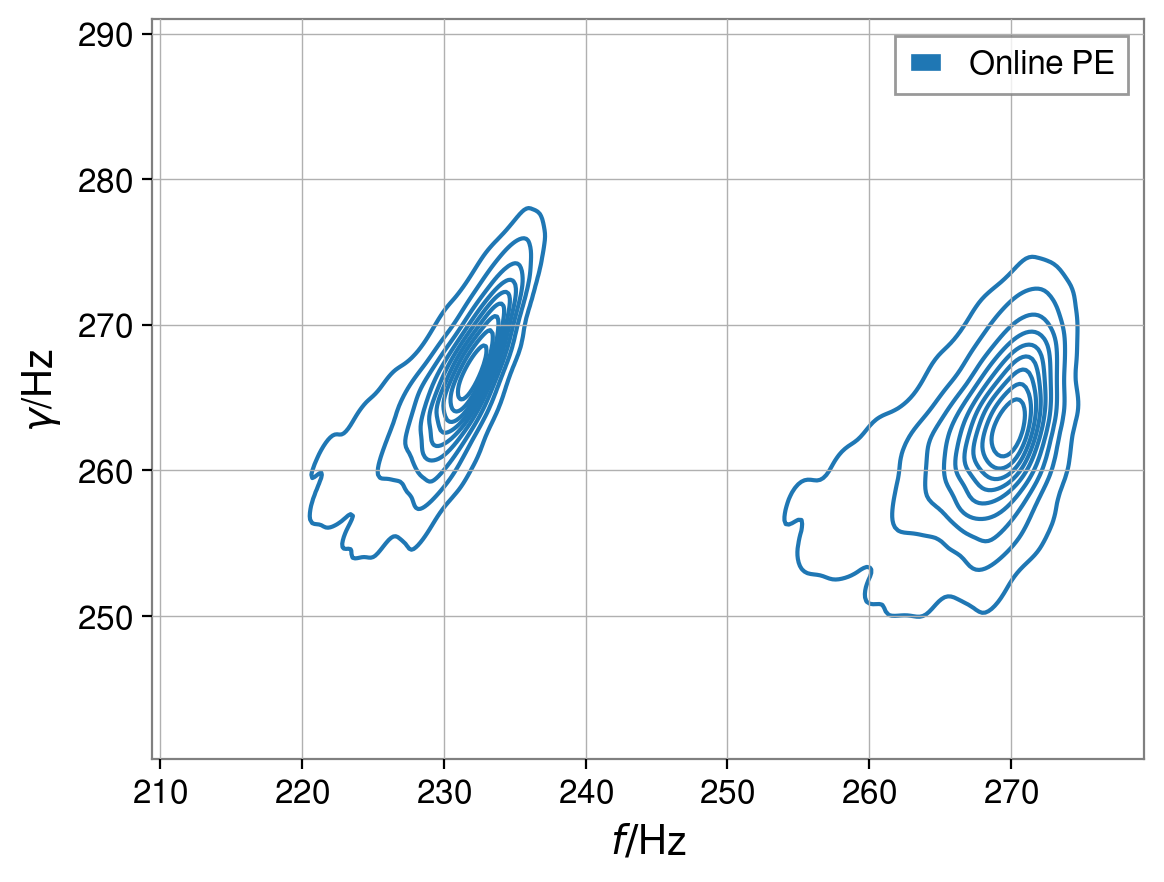

In [6]:
l, = pl.plot([], [], label='Online PE')
sns.kdeplot(x=pe_fs[(2,2,0)], y=pe_gammas[(2,2,0)], color=l.get_color())
sns.kdeplot(x=pe_fs[(2,1,0)], y=pe_gammas[(2,1,0)], color=l.get_color())
pl.xlabel(r'$f/$Hz')
pl.ylabel(r'$\gamma$/Hz')
pl.legend()

In [7]:
data = TimeSeries.read('L-L1_G429267_llhoft-1376089749.0-14.gwf', 'L1:GDS-CALIB_STRAIN_CLEAN')
times_list = [float(i/u.s) for i in data.times]
# has 14s of data sampled at 16K

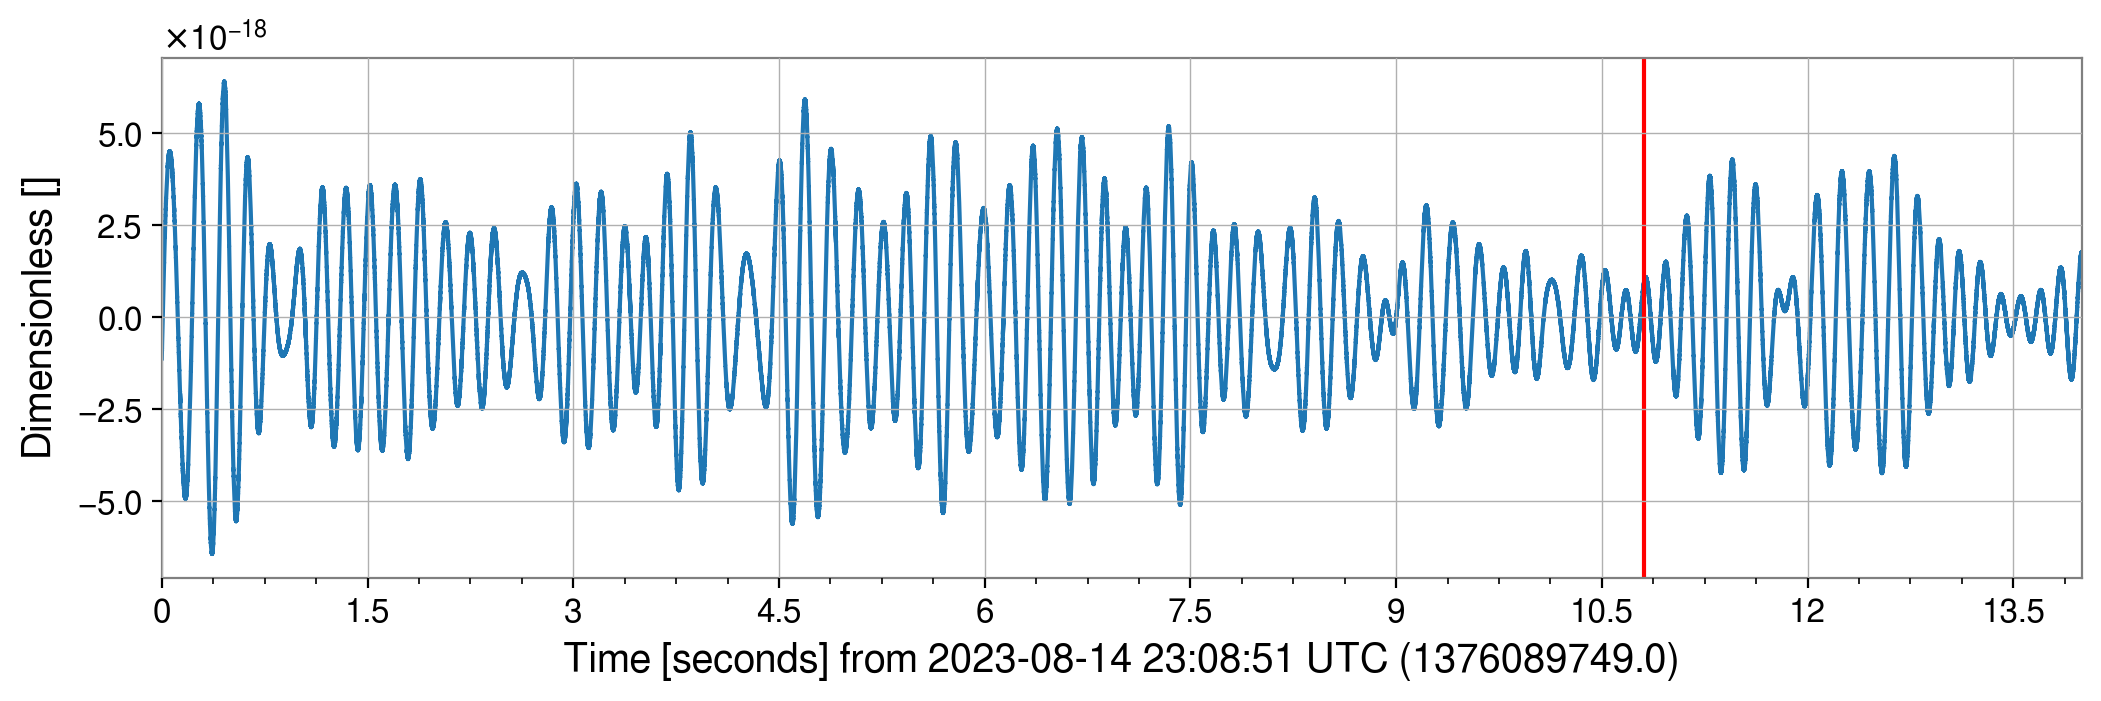

In [8]:
t_ref = 1376089759.81
data.plot()
pl.axvline(t_ref, c = 'r')

(1e-24, 1e-19)

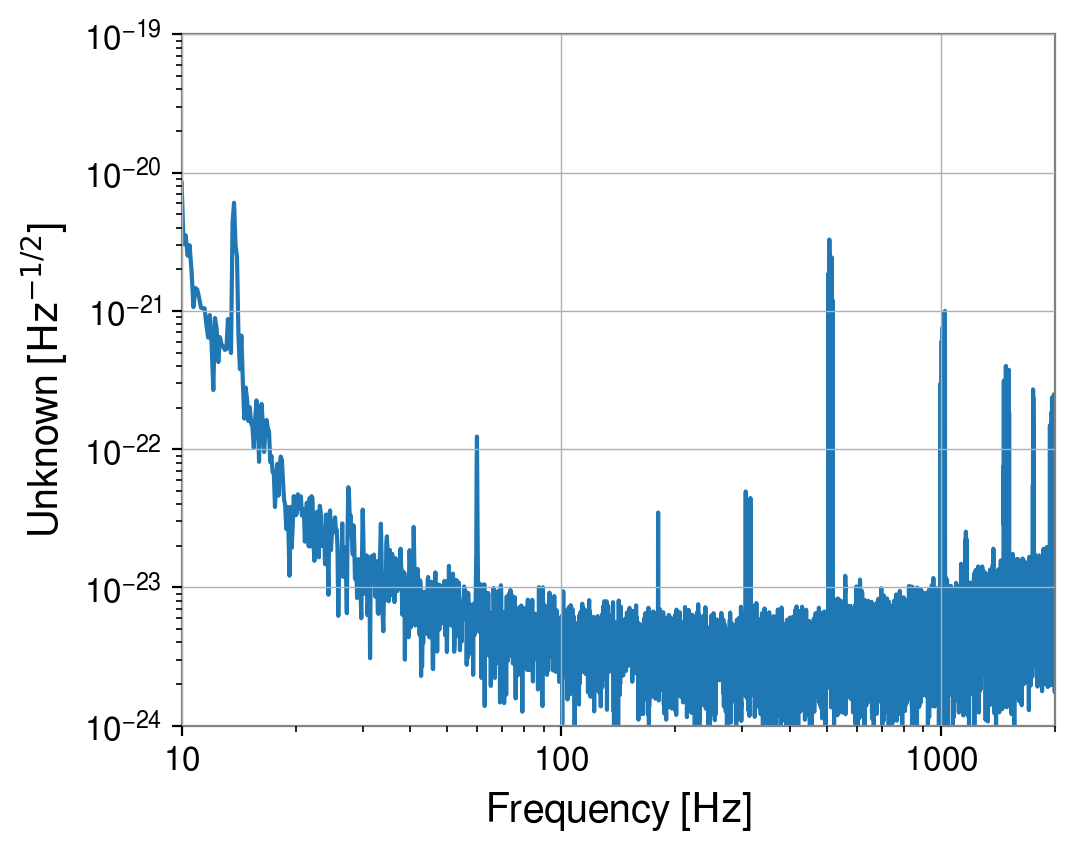

In [9]:
data.asd(fftlength = 8).plot()
pl.xlim(10,2000)
pl.ylim(1e-24, 1e-19)

(1376089759.61, 1376089759.9099998)

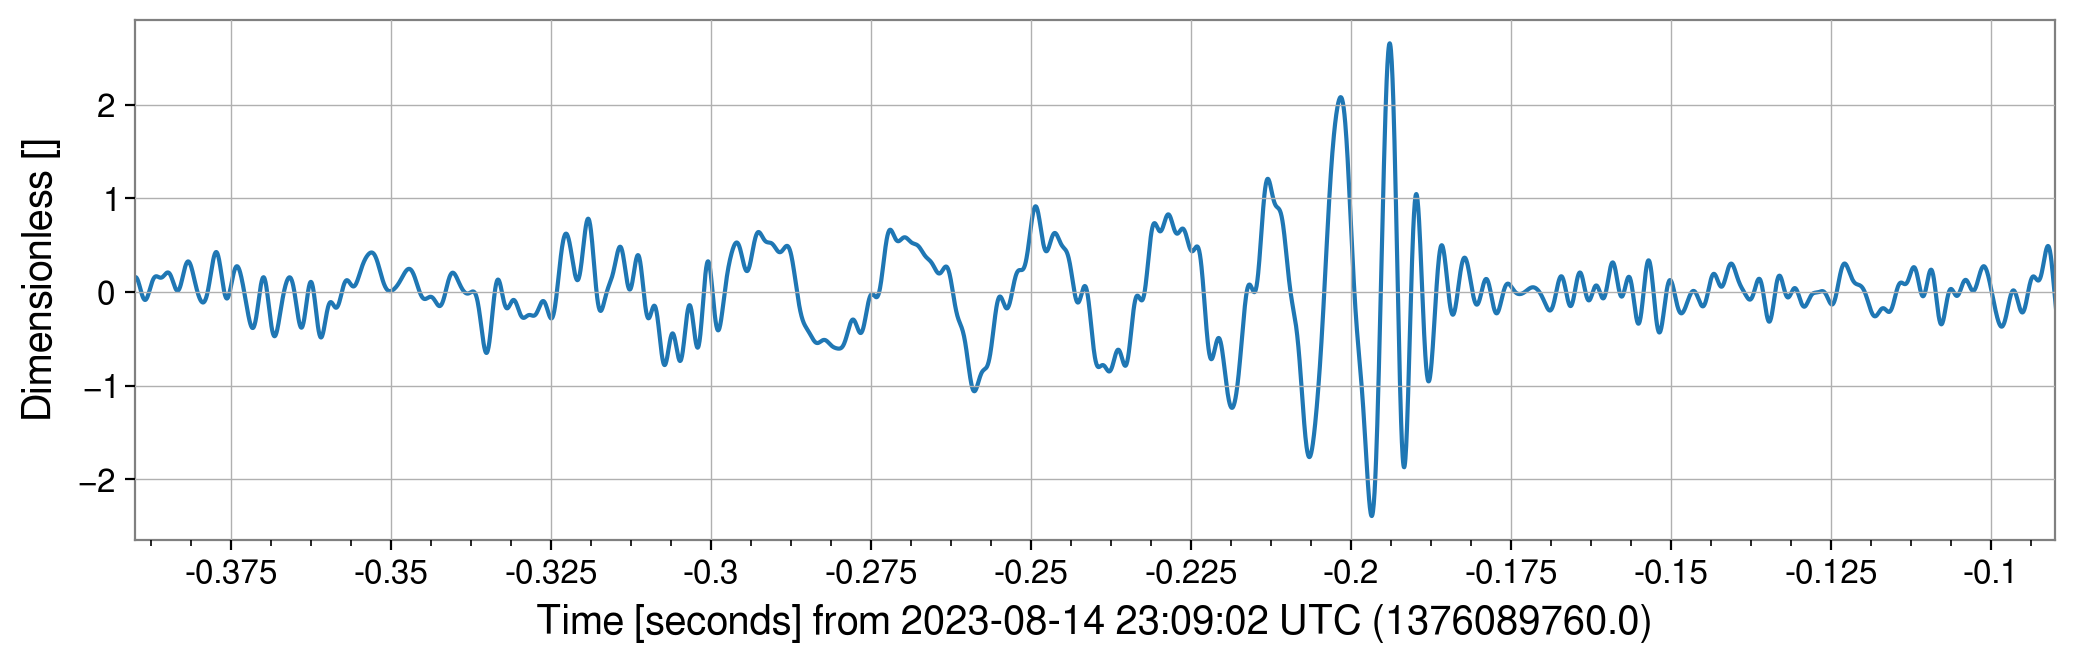

In [10]:
# -- Whiten and bandpass data
white_data = data.whiten()
bp_data = white_data.bandpass(30, 400)
fig3 = bp_data.plot()
pl.xlim(t_ref-0.2, t_ref+0.1)

In [11]:
t_0 = float(bp_data.times[np.argmax(bp_data.value)]/u.s)

In [12]:
t_0

1376089759.8060913

Download data

Set some parameters of GW150914

In [28]:
IMR = [63.06, 0.68]
mass_unit = qnm_filter.Filter.mass_unit(IMR[0]) 
time_offset = 0 # in units of mass

input = dict(model_list = [(2, 2, 0, 'p'),(2,2,1,'p')], #l, m, n, prograde/retrograde
             # trucation time (geocenter, in second)
             t_init = t_0+time_offset*mass_unit, #event time from https://gracedb.ligo.org/superevents/S230814ah/view/
             # length of the analysis segment (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)
output_str = ''
for item in input['model_list']:
    output_str += f"{item[0]}{item[1]}{item[2]}+"
filter_str = output_str.rstrip('+')

fit = qnm_filter.Network(**input)

Load data

In [29]:
fit.original_data['L1'] = qnm_filter.RealData(data.value, index = times_list)

Perform time alignment across detectors

In [30]:
fit.detector_alignment()

Condition data 

In [31]:
fit.condition_data('original_data', trim = 0.05, **input)

Cholesky-decomposition of the covariance matrix 

In [32]:
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [33]:
delta_mass = 2.0
delta_chi = 0.05
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [48]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data, target_probability=0.9)

In [49]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

In [50]:
IMR_analysis = [63.06, 0.68, [[1.23], [1.8]], [[0.02], [0.02]]]

Text(0.5, 1.0, 'S230814 \n $t_{init}$ + 0$M_\\odot$, filters = 220+221')

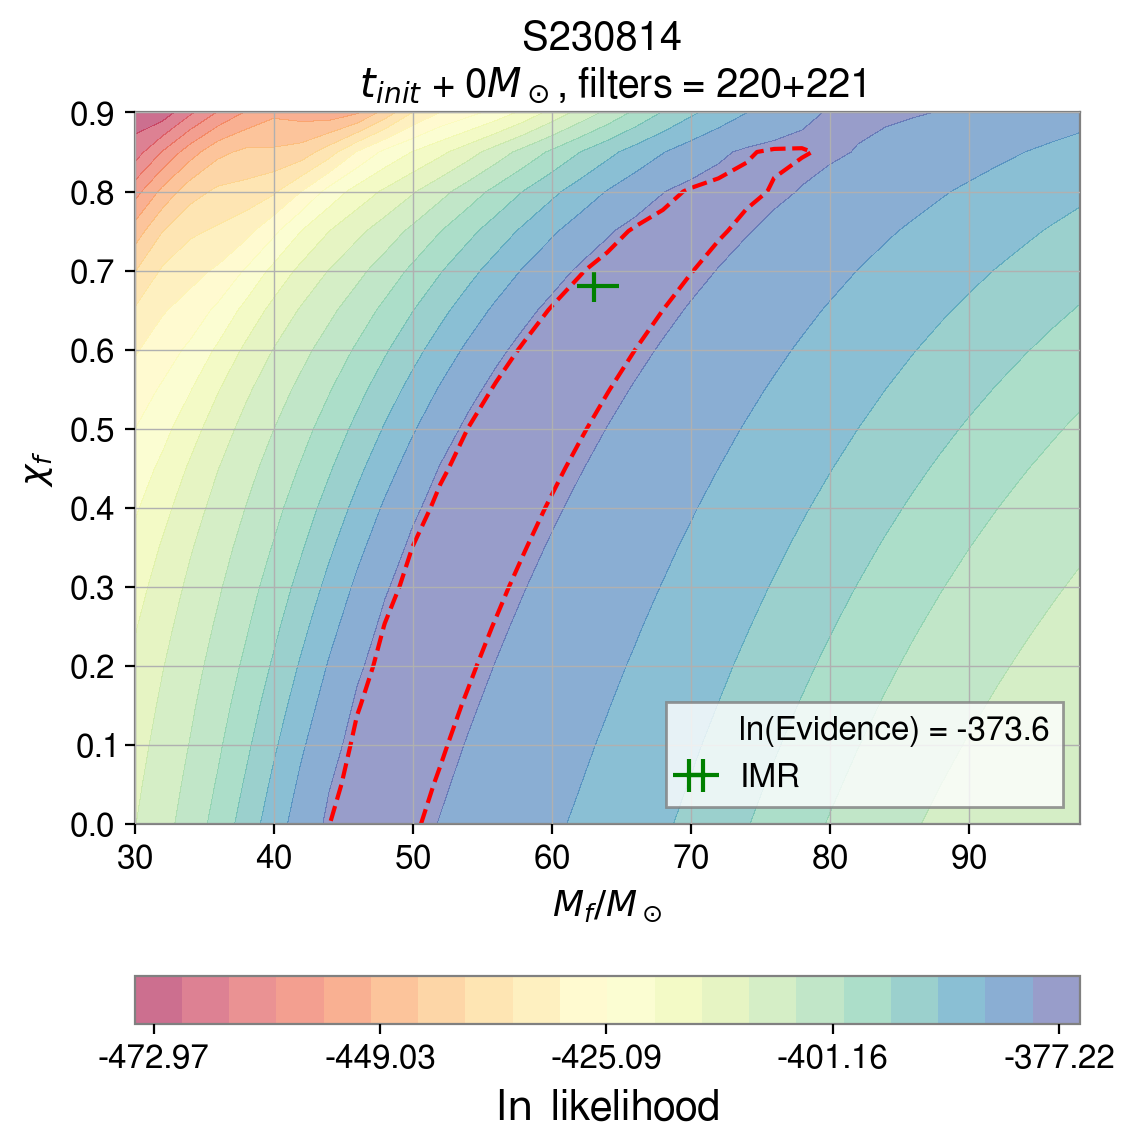

In [51]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.errorbar(x=IMR_analysis[0], y=IMR_analysis[1], xerr=IMR_analysis[2], yerr=IMR_analysis[3], 
           c='g', label='IMR')
ax.plot(np.NaN, np.NaN, '-', color='none', label='ln(Evidence) = %.1F' % evidence)


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend(loc = 'lower right')

ax.set_title('S230814 \n $t_{init}$ + ' + str(time_offset) +
             r'$M_\odot$, filters = ' + filter_str)
# pl.savefig('./gif_imgs/220+1_t={}M.png'.format(time_offset))

In [52]:
coordinates = dotted.collections[0].get_paths()[0].vertices

In [54]:
rd.qnms.get_ftau(coordinates[0][0], coordinates[0][1], l=2,m=2,n=0)

(238.60494183602498, 0.002801720501261966)

In [55]:
import qnm
import astropy.constants as c
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

freq220_arr = []
gamma220_arr = []

freq221_arr = []
gamma221_arr = []

for i in coordinates:
    mode_info = rd.qnms.get_ftau(i[0], i[1], l=2,m=2,n=0)
    freq220_arr.append(mode_info[0])
    gamma220_arr.append(1/mode_info[1])

for i in coordinates:
    mode_info = rd.qnms.get_ftau(i[0], i[1], l=2,m=2,n=1)
    freq221_arr.append(mode_info[0])
    gamma221_arr.append(1/mode_info[1])

In [56]:
freq210_arr = []
gamma210_arr = []
for i in coordinates:
    mode_info = rd.qnms.get_ftau(i[0], i[1], l=2,m=1,n=0)
    freq210_arr.append(mode_info[0])
    gamma210_arr.append(1/mode_info[1])

/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


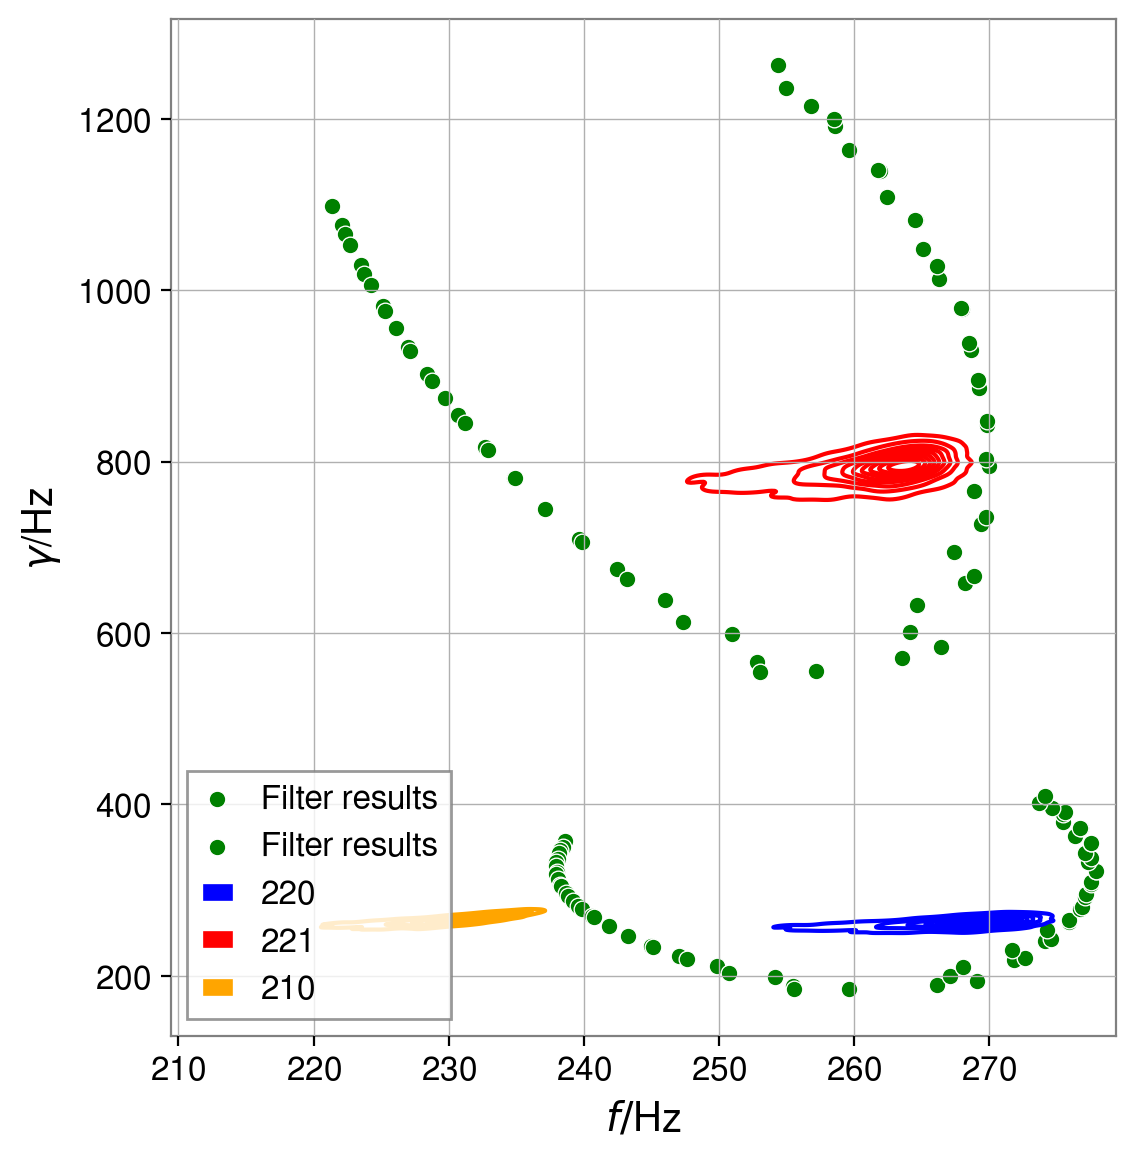

In [57]:
sns.kdeplot(x=pe_fs[(2,2,0)], y=pe_gammas[(2,2,0)], c='blue')
sns.kdeplot(x=pe_fs[(2,1,0)], y=pe_gammas[(2,1,0)], c='orange')
sns.kdeplot(x=pe_fs[(2,2,1)], y=pe_gammas[(2,2,1)], c='r')
sns.scatterplot(x=freq220_arr, y=gamma220_arr, c='g', label='Filter results')
sns.scatterplot(x=freq221_arr, y=gamma221_arr, c='g', label='Filter results')
# sns.scatterplot(x=freq210_arr, y=gamma210_arr, c='g', label='Filter results')
l, = pl.plot([], [], c='blue', label='220')
l, = pl.plot([], [], c='r', label='221')
l, = pl.plot([], [], c='orange', label='210')
pl.xlabel(r'$f/$Hz')
pl.ylabel(r'$\gamma$/Hz')
pl.legend()

Plot 2d contours